In [1]:

%load_ext autoreload
%autoreload 2

In [20]:

from transformers import AutoImageProcessor
import torch
from torch.utils.data import DataLoader

from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
# from uav_active_sensing.modeling.ppo import train_ppo, make_env, PPOConfig, PPOAgent
from uav_active_sensing.plots import visualize_tensor

from stable_baselines3 import PPO, SAC
from uav_active_sensing.modeling.rl_agent_feature_extractor import CustomResNetFeatureExtractor

In [26]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4

image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

policy_kwargs = dict(
    features_extractor_class=CustomResNetFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=512),
)

resnet_rl_model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
      n_steps=rl_num_steps,
    batch_size=rl_batch_size
)

for i, batch in enumerate(tiny_imagenet_train_loader):
    # Set image with batch change: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html
    vec_env = resnet_rl_model.get_env()  
    vec_env.env_method("set_img", batch)
    resnet_rl_model.learn(total_timesteps=2 * rl_num_steps, progress_bar=False)
    
    if i == 1:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 4  |
|    iterations      | 1  |
|    time_elapsed    | 3  |
|    total_timesteps | 16 |
---------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31          |
|    ep_rew_mean          | 7.96        |
| time/                   |             |
|    fps                  | 0           |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 32          |
| train/                  |             |
|    approx_kl            | 0.026978336 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.00609     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.078    

In [36]:
# test_env = ImageExplorationEnv(env_config)
test_env = resnet_rl_model.env.envs[0].env


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[-0.1282551   0.02449176 -0.40526557], Reward=0.4446693956851959
Step 2: Action=[-0.12824275  0.02449564 -0.40526748], Reward=0.0
Step 3: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 4: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.0
Step 5: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 6: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.0
Step 7: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 8: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.0
Step 9: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 10: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.0
Step 11: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 12: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.0
Step 13: Action=[-0.12825263  0.02448862 -0.4052647 ], Reward=0.4446693956851959
Step 14: Action=[-0.12825263  0.02448862 -0.40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2885153].


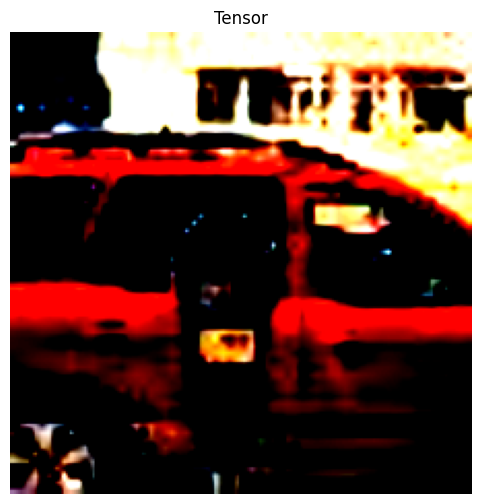

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-0.9678431].


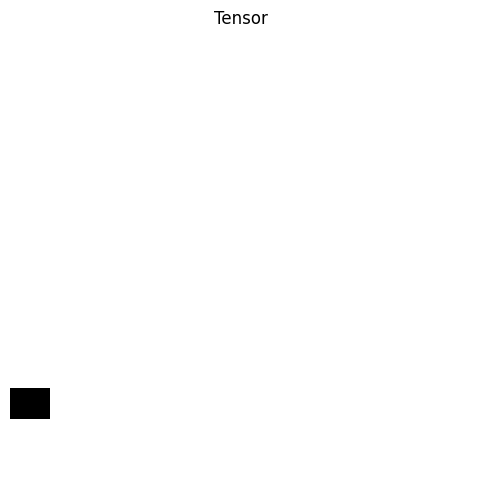

In [37]:
visualize_tensor(test_env.img)
visualize_tensor(test_env.sampled_img)